# Проект: классификация

### <center> ВВЕДЕНИЕ

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется прямым маркетингом. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

*  Банкам хотелось бы уметь выбирать среди своих клиентов именно тех, которые с наибольшей вероятностью воспользуются тем или иным предложением, и связываться именно с ними.

* Бизнес-задача: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

* Техническая задача Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [1]:
# Импорт библиотек
import pandas as pd # Для чтения и обработки
import numpy as np # Для матричных измерений
import matplotlib.pyplot as plt # Для графиков
import seaborn as sns # Для графиков
from  sklearn.ensemble import IsolationForest # Ансамбль
from sklearn.ensemble import StackingClassifier # Стэкинг 
from sklearn.model_selection import GridSearchCV # Для перебора гиперпараметров
from sklearn.feature_selection import RFE # Для подбора значимых признаков
import optuna # Для подбора гиперпараметров
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder # Кодировщик
from sklearn import linear_model # Линейные модели
from sklearn import tree # Дерево решений
from sklearn import ensemble # Ансамбли
from sklearn import metrics # Метрики
from sklearn import preprocessing # Предобработка
from sklearn.model_selection import train_test_split # Разбивка данных
from sklearn.feature_selection import SelectKBest, f_classif # Преобразование выборок

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
# Прочитаем данные и выведем первые 5 строк
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
# Исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Пропуски в данных есть только в одном признаке balance, в остальном всё отлично.

### Задание 2

Проверим признаки на пропущенные значения, может быть null/nan обозначены специальным словом.

In [4]:
# Есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Проверили признак сферы работы, действительно есть скрытое слово unknown.

### Задание 3

Обработаем признак баланса.

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df.balance.apply(lambda x: float((str(x)).replace(' ', '') \
    .replace('$', '').replace(',', '.')))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11137 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [6]:
# Проверим статистическую информацию
round(df.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.232,11.913,18.0,32.0,39.0,49.00,95.0
balance,11137.0,1529.129,3228.115,-6847.0,123.0,550.0,1708.00,81204.0
day,11162.0,15.658,8.421,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.994,347.128,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508,2.722,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330,108.758,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.833,2.292,0.0,0.0,0.0,1.00,58.0


### Задание 4

Заполним пропущенные значения медианой.

In [7]:
# Обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df.balance.fillna(df['balance'].median())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [8]:
# Проверим статистическую информацию
round(df.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.232,11.913,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1526.936,3224.830,-6847.0,123.0,550.0,1699.00,81204.0
day,11162.0,15.658,8.421,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.994,347.128,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508,2.722,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330,108.758,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.833,2.292,0.0,0.0,0.0,1.00,58.0


### Задание 5

In [9]:
# Надо проверить категориальные признаки на пропуски, напишем функцию
def get_unique(data, columns):
    """Функция принимает на вход выборку и признаки, выводим уникальные значения.

    Args:
        data (_type_): Данные
        columns (_type_): Признаки
    """
    for col in columns:
        if data[col].dtypes != 'object':
            pass
        else:
            print(f"{col} unique: {data[col].unique()}")
            print('*'*90)

In [10]:
# Применим функцию 
get_unique(data=df, columns=df.columns)

job unique: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student']
******************************************************************************************
marital unique: ['married' 'single' 'divorced']
******************************************************************************************
education unique: ['secondary' 'tertiary' 'primary' 'unknown']
******************************************************************************************
default unique: ['no' 'yes']
******************************************************************************************
housing unique: ['yes' 'no']
******************************************************************************************
loan unique: ['no' 'yes']
******************************************************************************************
contact unique: ['unknown' 'cellular' 'telephone']
**********************************************

Пропущенные значения есть в признаках:
* job 
* education
* contact 
* poutcome

In [11]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(
    lambda x: df['job'].mode()[0] if x == 'unknown' else x
)
df['education'] = df['education'].apply(
    lambda x: df['education'].mode()[0] if x == 'unknown' else x
)

# Проверим 
print(df['job'].unique())
print('')
print(df['education'].unique())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']

['secondary' 'tertiary' 'primary']


In [12]:
# Проверим топ 3 популярных работ и популярных образований 
print(df.job.value_counts().head(3))
print("*"*30)
print(df.education.value_counts().head(3))

management     2636
blue-collar    1944
technician     1823
Name: job, dtype: int64
******************************
secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64


Самая популярная работа management, а самое популярное образование secondary.

In [13]:
# Напишем маску для поиска 
mask = (df.job == 'management') & (df.education == 'secondary')

# Выведем статистическую информацию
round(df[mask].describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
age,376.0,44.356,11.369,24.0,35.00,44.0,53.00,78.0
balance,376.0,1598.883,2440.042,-994.0,171.00,703.0,2206.00,19268.0
day,376.0,16.295,8.664,1.0,8.00,17.0,23.00,31.0
duration,376.0,364.473,389.033,8.0,121.75,260.0,459.25,3881.0
campaign,376.0,2.699,4.024,1.0,1.00,2.0,3.00,63.0
pdays,376.0,51.181,108.090,-1.0,-1.00,-1.0,45.50,683.0
previous,376.0,0.835,2.124,0.0,0.00,0.0,1.00,15.0


### Задание 6

In [14]:
# Напишем функцию для поиска границ 
def outliers_iqr(data, feature):
    """Функция принимает выборку и признак, возвращает очищенные данные, 
    левую и правую границу, разницу.

    Args:
        data (_type_): Выборка.
        feature (_type_): Признак.
    """
    # Фисируем серию
    x = data[feature]
    # Вычисляем квантили
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    # Вычисляем разницу
    iqr = quartile_3 - quartile_1
    # Вычисляем границы
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    # Возвращаем границы 
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return cleaned, lower_bound, upper_bound, iqr
    

In [15]:
# Обработаем признак баланса
df, low, upp, iqr = outliers_iqr(df, 'balance')
print(f"iqr: {iqr}\n low: {low}\n upp: {upp}")
df.shape

iqr: 1576.0
 low: -2241.0
 upp: 4063.0


(10105, 17)

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64
no     0.54
yes    0.46
Name: deposit, dtype: float64


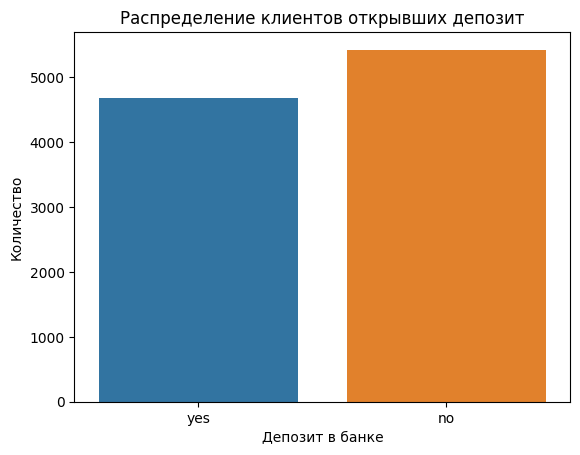

In [16]:
# Изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
print(df.deposit.value_counts())
print(round(df.deposit.value_counts(True), 2))

# Визуализируем
cnt_plt = sns.countplot(df, x='deposit')
cnt_plt.set_ylabel("Количество")
cnt_plt.set_xlabel("Депозит в банке")
cnt_plt.set_title("Распределение клиентов открывших депозит");

Клиентов открывших депозит меньше, целевой признак несбалансирован.

### Задания 2 и 3

При построении графиков, будем делать разбивку по депозитам, чтобы лучше ориентироваться в данных.

Максимальный возраст: 95
 Минимальный возраст: 18


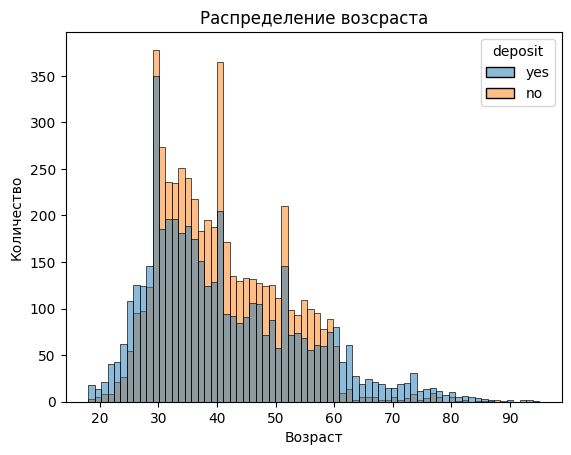

In [17]:
# Рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print(f"Максимальный возраст: {df.age.max()}\n Минимальный возраст: {df.age.min()}")

# Посмотрим на графике
hist = sns.histplot(df, x='age', bins=70, hue='deposit')
hist.set_ylabel("Количество")
hist.set_xlabel("Возраст")
hist.set_title("Распределение возсраста");

### Задания 4 и 5

Минимальная продолжительность звонка: 2
Максимальная продолжительность звонка: 3881


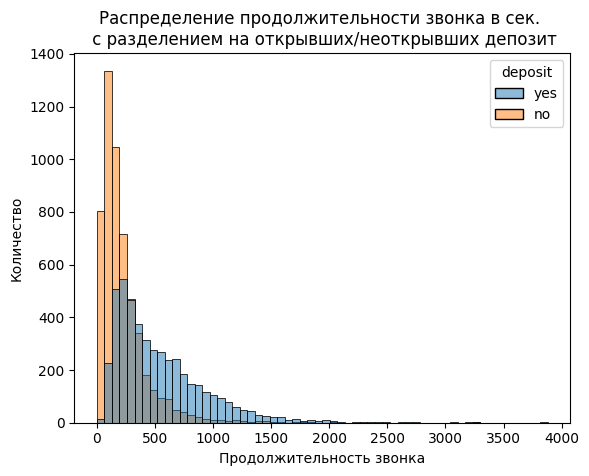

In [18]:
# Рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
print(f"Минимальная продолжительность звонка: {df.duration.min()}")
print(f"Максимальная продолжительность звонка: {df.duration.max()}"
      )
# Постройте визуализации, иллюстрирующие результаты
hist = sns.histplot(df, x='duration', bins=60, hue='deposit')
hist.set_ylabel('Количество')
hist.set_xlabel("Продолжительность звонка")
hist.set_title("Распределение продолжительности звонка в сек. \n с разделением на открывших/неоткрывших депозит");

Месяцы: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'], кол-во: 12

may    26.0
jul    14.0
aug    14.0
jun    11.0
apr     8.0
nov     8.0
feb     7.0
oct     3.0
jan     3.0
sep     3.0
mar     2.0
dec     1.0
Name: month, dtype: float64


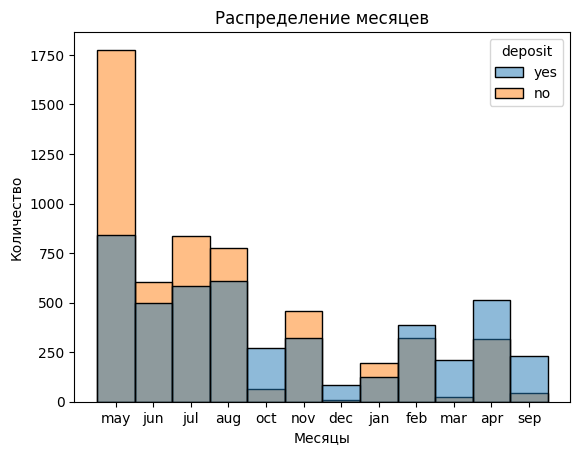

In [19]:
# Проверим признак месяца 
print(f"Месяцы: {df.month.unique()}, кол-во: {len(df.month.unique())}\n")

# Посмотрим на распределение месяца в процентах
print(round(df.month.value_counts(True), 2) * 100)

# Распределим на графике по количеству 
hist = sns.histplot(df, x='month', hue='deposit')
hist.set_ylabel("Количество")
hist.set_xlabel("Месяцы")
hist.set_title("Распределение месяцев");

Сферы занятости: ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student'], кол-во: 11


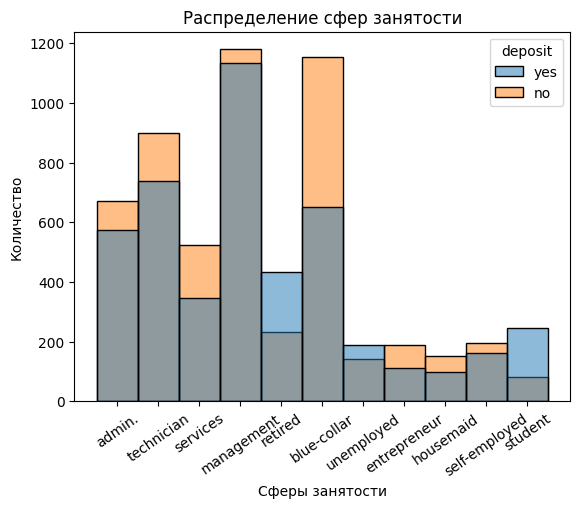

In [20]:
# Проверим сферы занятости
print(f"Сферы занятости: {df.job.unique()}, кол-во: {len(df.job.unique())}")

# Так же выведем график распределения сфер занятости
hist = sns.histplot(df, x='job', hue='deposit')
hist.xaxis.set_tick_params(rotation=35)
hist.set_ylabel("Количество")
hist.set_xlabel("Сферы занятости")
hist.set_title("Распределение сфер занятости");

### Задание 6

In [21]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
group = df.groupby('poutcome')['deposit']
group.value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 7

In [22]:
# Узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# На графике вышел уже видна эта информация, проверим точное количество
group = df.groupby('month')['deposit']
group.value_counts()

month  deposit
apr    yes         513
       no          317
aug    no          775
       yes         610
dec    yes          84
       no            9
feb    yes         386
       no          323
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    yes         213
       no           24
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    yes         273
       no           62
sep    yes         232
       no           46
Name: deposit, dtype: int64

### Задание 8

In [23]:
# Cоздайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
# Напишем функцию для замены на группы 
def get_group_age(age):
    """Функция принимает возраст и возвращает группу.

    Args:
        age (_type_): Возраст
    """
    if age < 30:
        return '<30'
    elif age >= 30 and age < 40:
        return '30-39'
    elif age >= 40 and age < 50:
        return '40-49'
    elif age >= 50 and age < 60:
        return '50-59'
    elif age >= 60:
        return '60+'

group_age  deposit
30-39      no         2245
           yes        1716
40-49      no         1444
           yes         938
50-59      no          984
           yes         670
60+        yes         496
           no          157
<30        yes         861
           no          594
Name: deposit, dtype: int64


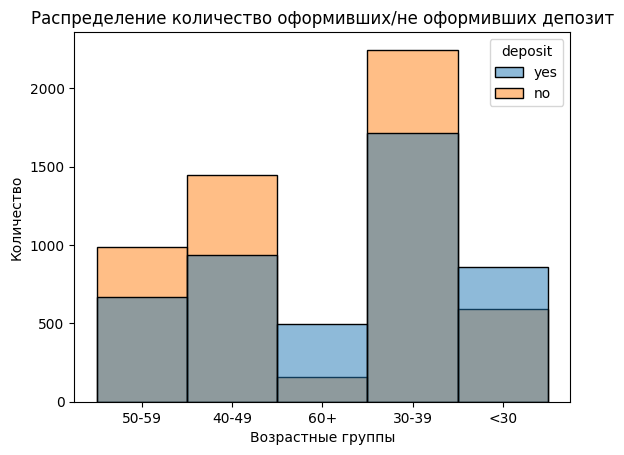

In [24]:
# Применим нашу функцию
df['group_age'] = df.age.apply(lambda x: get_group_age(x))

# Сгруппируем данные и проверим соотношение депозитов клиентов  
group_age = df.groupby('group_age')['deposit']
print(group_age.value_counts())

# Отобразим график 
histplot = sns.histplot(df, x='group_age', hue='deposit')
histplot.set_ylabel("Количество")
histplot.set_xlabel("Возрастные группы")
histplot.set_title("Распределение количество оформивших/не оформивших депозит");

### Задания 9 и 10

marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    yes        1716
          no         1497
Name: deposit, dtype: int64


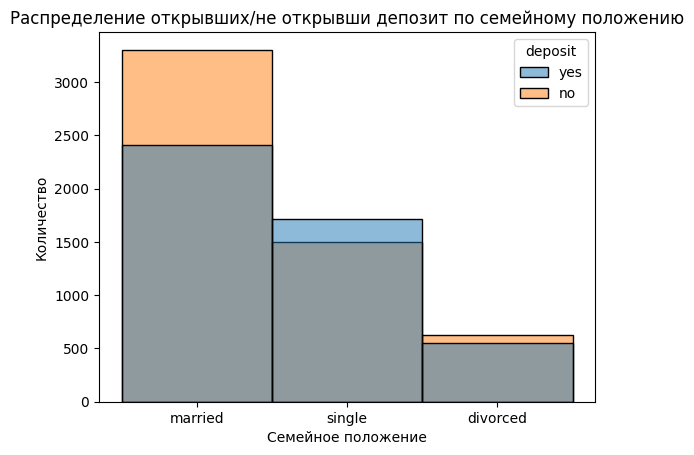

In [25]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
group = df.groupby('marital')['deposit']
print(group.value_counts())

# Построим график 
hist = sns.histplot(df, x='marital', hue='deposit')
hist.set_xlabel("Семейное положение")
hist.set_ylabel("Количество")
hist.set_title("Распределение открывших/не открывши депозит по семейному положению");

education  deposit
primary    no          832
           yes         517
secondary  no         3066
           yes        2451
tertiary   yes        1713
           no         1526
Name: deposit, dtype: int64


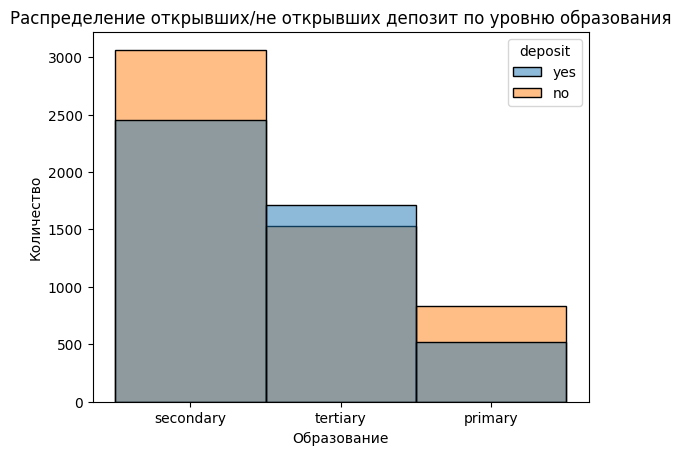

In [26]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
group = df.groupby('education')['deposit']
print(group.value_counts())

# Построим график 
hist = sns.histplot(df, x='education', hue='deposit')
hist.set_xlabel("Образование")
hist.set_ylabel("Количество")
hist.set_title("Распределение открывших/не открывших депозит по уровню образования");

job            deposit
admin.         no          672
               yes         574
blue-collar    no         1155
               yes         652
entrepreneur   no          189
               yes         111
housemaid      no          153
               yes          99
management     no         1180
               yes        1135
retired        yes         432
               no          231
self-employed  no          197
               yes         161
services       no          523
               yes         345
student        yes         245
               no           81
technician     no          900
               yes         738
unemployed     yes         189
               no          143
Name: deposit, dtype: int64


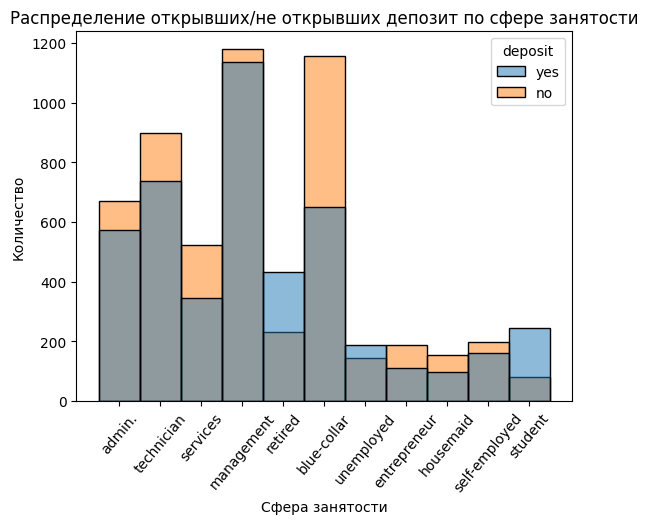

In [27]:
# Постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
group = df.groupby('job')['deposit']
print(group.value_counts())

# Построим график 
hist = sns.histplot(df, x='job', hue='deposit')
hist.set_xlabel("Сфера занятости")
hist.xaxis.set_tick_params(rotation=50)
hist.set_ylabel("Количество")
hist.set_title("Распределение открывших/не открывших депозит по сфере занятости");

### Задание 11

In [28]:
# Постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
# Разобъём выборку на открывших и не открывшыих депозит 
group_deposit_yes = df[df.deposit == 'yes']
group_deposit_no = df[df.deposit == 'no']

# Проверим показатели 
group_yes = group_deposit_yes.groupby(['education', 'marital'])['deposit']
print(group_yes.value_counts())
print('*'*50)
group_no = group_deposit_no.groupby(['education', 'marital'])['deposit']
print(group_no.value_counts())

education  marital   deposit
primary    divorced  yes          96
           married   yes         339
           single    yes          82
secondary  divorced  yes         283
           married   yes        1289
           single    yes         879
tertiary   divorced  yes         174
           married   yes         784
           single    yes         755
Name: deposit, dtype: int64
**************************************************
education  marital   deposit
primary    divorced  no           91
           married   no          641
           single    no          100
secondary  divorced  no          370
           married   no         1830
           single    no          866
tertiary   divorced  no          163
           married   no          832
           single    no          531
Name: deposit, dtype: int64


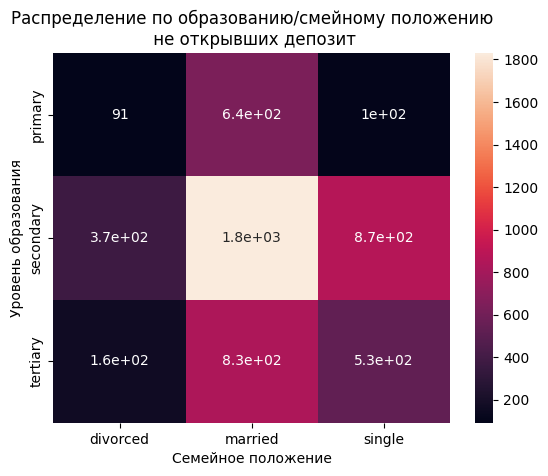

In [29]:
# Построим тепловую карту для не открывших депозит 
pivot_no = group_deposit_no.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)
heatmap_no = sns.heatmap(pivot_no, annot=True)
heatmap_no.set_xlabel("Семейное положение")
heatmap_no.set_ylabel("Уровень образования")
heatmap_no.set_title("Распределение по образованию/смейному положению\n не открывших депозит");

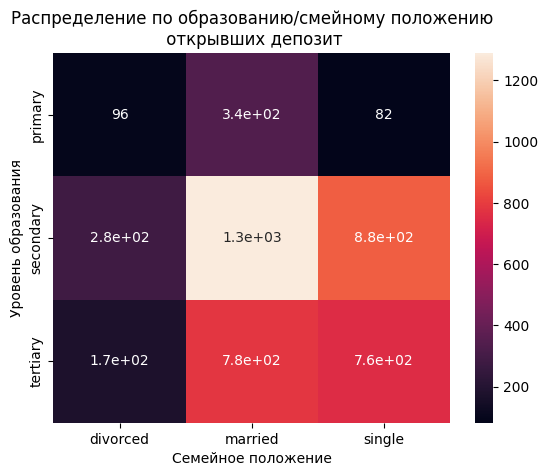

In [30]:
# Построим тепловую карту для открывших депозит 
pivot_yes = group_deposit_yes.pivot_table(
    values='deposit',
    columns='marital',
    index='education',
    aggfunc='count'
)
heatmap_yes = sns.heatmap(pivot_yes, annot=True)
heatmap_yes.set_xlabel("Семейное положение")
heatmap_yes.set_ylabel("Уровень образования")
heatmap_yes.set_title("Распределение по образованию/смейному положению\n открывших депозит");

## Часть 3: преобразование данных

Преобразуем наши данные в числовой формат, чтобы данные можно было передать в модель.

### Задание 1

In [31]:
# Преобразуйте уровни образования
# Напишем модель кодировщика
label_encoder = LabelEncoder()
df['education'] = label_encoder.fit_transform(df['education'])

# Выведем сумму получившегося признака
np.sum(df['education'])

11995

In [32]:
# Обработаем приизнак group_age
# Повторно создаём кодировщик
label_encoder = LabelEncoder()
df['group_age'] = label_encoder.fit_transform(df['group_age'])

# Проверим что получилось 
df.group_age.unique()

array([2, 1, 3, 0, 4])

### Задания 2 и 3

In [33]:
# Преобразуйте бинарные переменные в представление из нулей и единиц
# Перекодируем признак deposit 
df['deposit'] = df.deposit.apply(lambda x: 1 if x == 'yes' else 0)

# Провери стандартное отклонение 
round(df.deposit.std(), 3)

0.499

Сделаем то же самое для других бинарных переменных, которых у нас три:

* 'default';
* 'housing';
* 'loan'.

In [34]:
# Преобразуем другие бинрные признаки 
df['default'] = df.default.apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df.housing.apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df.loan.apply(lambda x: 1 if x == 'yes' else 0)

# Вычислим среднее арефмитическое, сложим результат и округлим
print(round(df.default.mean() + df.housing.mean() + df.loan.mean(), 3))

0.635


### Задание 4

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

* 'job';
* 'marital';
* 'contact';
* 'month';
* 'poutcome'.

In [35]:
# Cоздайте дамми-переменные, провери размерность и выведем 5 строк
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
print(df.shape)
df.head()

(10105, 46)


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1


### Задания 5 и 6

Проверим данные на корреляцию.

In [36]:
# Постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr = df.corr()
corr.style.background_gradient()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,group_age,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.191124,-0.009929,0.115164,-0.164196,-0.026357,0.000396,-0.006007,-0.001143,0.006107,0.025383,0.024357,0.122622,-0.057502,-0.065917,0.028390,0.092661,-0.036163,0.545524,-0.027947,-0.077266,-0.231436,-0.074596,0.001263,0.185312,0.316681,-0.464737,-0.074062,0.194455,-0.036224,-0.026208,0.060980,0.031151,0.014729,0.017477,-0.003662,0.009769,0.024785,-0.119656,0.026875,0.056998,0.036352,0.001994,-0.020942,0.060009,-0.031455
education,-0.191124,1.000000,-0.015692,0.043251,-0.094350,-0.052566,0.008989,-0.016869,-0.012280,0.024123,0.025368,0.098253,-0.099057,-0.055817,-0.371796,0.024219,-0.144242,0.518735,-0.148800,0.091001,-0.103846,-0.009494,0.047966,-0.031813,-0.033425,-0.133514,0.165140,0.172697,-0.080767,-0.140256,0.015456,0.102218,0.004171,0.036743,-0.002330,-0.049832,-0.036503,0.052196,-0.104157,0.028704,0.027617,0.030846,0.019845,0.015103,0.070489,-0.069069
default,-0.009929,-0.015692,1.000000,-0.110928,0.009551,0.074786,0.018724,-0.008162,0.033404,-0.037323,-0.036605,-0.038872,0.002058,-0.022421,0.022989,0.023264,0.019273,-0.000055,-0.018524,0.008924,-0.020168,-0.019190,0.004419,0.011120,0.021028,-0.007670,-0.006322,-0.028878,-0.021596,0.044621,-0.018812,-0.003966,-0.012456,-0.020260,0.003382,0.048653,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.115164,0.043251,-0.110928,1.000000,-0.094919,-0.113089,-0.009987,0.025781,-0.042689,0.045155,0.060419,0.135893,0.027820,-0.028057,-0.049484,-0.008727,0.000907,0.039205,0.091421,0.009889,-0.037633,0.007133,-0.010460,0.009689,-0.030406,0.032056,-0.013176,0.030039,0.061140,-0.069737,0.050392,-0.008252,0.027092,0.010160,-0.011331,-0.086824,0.039753,0.043832,-0.098073,0.081861,0.057041,0.047841,0.031040,0.028111,0.073358,-0.085456
housing,-0.164196,-0.094350,0.009551,-0.094919,1.000000,0.072252,-0.022644,0.038492,0.006257,0.064138,-0.000221,-0.200290,-0.153188,0.063547,0.194115,0.006600,-0.063824,-0.077697,-0.168785,-0.019555,0.080129,-0.124261,0.004772,-0.059712,0.009686,0.036857,-0.045904,-0.186832,-0.084942,0.255649,0.031485,-0.235772,-0.059625,-0.079198,-0.090039,-0.029806,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.026357,-0.052566,0.074786,-0.113089,0.072252,1.000000,0.019136,0.001476,0.033889,-0.030788,-0.020087,-0.107240,-0.028775,0.049098,0.056857,0.038298,-0.028973,-0.052683,-0.045674,0.004113,0.032109,-0.071385,0.009501,-0.039883,0.028408,0.044692,-0.067140,0.000653,-0.016394,0.009172,-0.040164,-0.064208,-0.029521,-0.012067,0.003325,0.163249,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,0.000396,0.008989,0.018724,-0.009987,-0.022644,0.019136,1.000000,-0.016695,0.142169,-0.078757,-0.059739,-0.056878,-0.007096,-0.010680,-0.019876,-0.005463,0.010920,0.003025,-0.005226,0.001565,0.002787,-0.010712,0.031050,-0.001380,0.003626,0.001760,-0.004371,-0.006511,0.013647,-0.001105,0.110547,-0.001758,-0.011651,-0.236222,0.225136,0.130897,-0.182032,-0.044303,-0.014580,0.056471,0.072179,-0.068744,-0.071175,-0.008806,-0.044366,0.085442
duration,-0.006007,-0.016869,-0.008162,0.025781,0.038492,0.001476,-0.016695,1.000000,-0.042576,-0.033053,-0.034233,0.457818,0.002826,-0.023585,0.032253,0.000594,-0.010009,-0.024309,0.006052,0.014513,0.013911,-0.017974,-0.007488,0.027641,0.023425,-0.037747,0.024042,0.022006,-0.022244,-0.010665,0.027398,-0.024372,0.007100,-0.025231,-0.010272,0.056

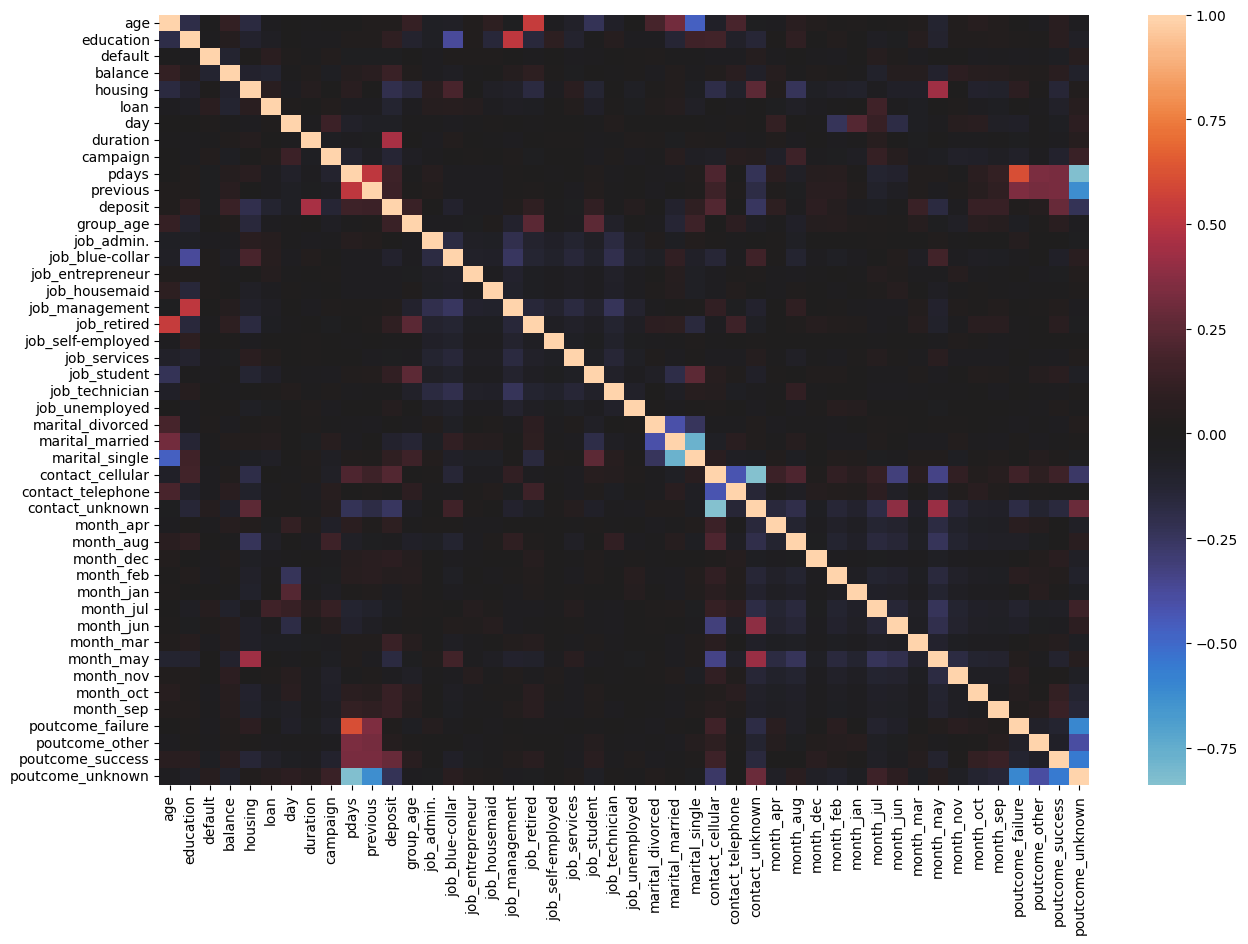

In [37]:
# Отобразим тепловую карту корреляции
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, ax=ax, center=0);

### Задания 7 и 8

Переходи к разбивке данных.

In [38]:
# Разбиваем выборку на данные и вектор правильных ответов 
X = df.drop(['deposit'], axis=1)
y = df['deposit']

# Разбиваем выборки на тренировачную и тестовые выборки 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [39]:
# Рассчитайте необходимые показатели
# Проверим размер тестовой выборки и узнаем среднее значение целевой переменной 
print(X_test.shape)
print(np.round(y_test.mean(), 2))

(3335, 45)
0.46


### Задание 9

С помощью SelectKBest определим признаки для модели ml.

In [40]:
# С помощью SelectKBest отберите 15 наиболее подходящих признаков
# Создаём модель, обучаем и проверяем признаки 
k_best = SelectKBest(score_func=f_classif, k=15)
k_best.fit(X_train, y_train)
k_best.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'group_age', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [41]:
# В выборках сохраняем только нужные признаки 
X_train = X_train[k_best.get_feature_names_out()]
X_test = X_test[k_best.get_feature_names_out()]

### Задание 10

Применим нормализацию, будем использовать MinMaxScaler.

In [42]:
# Нормализуйте данные с помощью minmaxsxaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_train_scaler = min_max_scaler.transform(X_train)
X_test_scaler = min_max_scaler.transform(X_test)

In [43]:
# Рассчитаем среднее арифмитечское для первого предикатора на тестовой выборке 
X_test_scaler[:,0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Переходим к обучению моделей.

### Задание 1

In [44]:
# Обучите логистическую регрессию и рассчитайте метрики качества
# Напишем модель 
lr_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)

# Обучим нашу модель 
lr_model.fit(X_train_scaler, y_train)

# Делаем предсказание 
lr_train_pred = lr_model.predict(X_train_scaler)
lr_test_pred = lr_model.predict(X_test_scaler)

# Выводим метрику по тестовой выборке
print("Test accuracy: {:.2f}".format(metrics.accuracy_score(y_test, lr_test_pred)))

Test accuracy: 0.80


### Задания 2,3,4

In [45]:
# Обучите решающие деревья, настройте максимальную глубину
tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

# Обучаем модель
tree_model.fit(X_train_scaler, y_train)

# Делаем предсказания 
tree_train_pred = tree_model.predict(X_train_scaler)
tree_test_pred = tree_model.predict(X_test_scaler)

# Выводим метрики
print("Train accuracy: {:.2f}".format(metrics.accuracy_score(y_train, tree_train_pred)))
print("Test accuracy: {:.2f}".format(metrics.accuracy_score(y_test, tree_test_pred)))

Train accuracy: 1.00
Test accuracy: 0.75


In [46]:
# Подберём глубину дерева
tree_model = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=6)

# Обучаем модель
tree_model.fit(X_train_scaler, y_train)

# Делаем предсказания 
tree_train_pred = tree_model.predict(X_train_scaler)
tree_test_pred = tree_model.predict(X_test_scaler)

# Выводим метрики
print("Train accuracy: {:.2f}".format(metrics.accuracy_score(y_train, tree_train_pred)))
print("Test accuracy: {:.2f}".format(metrics.accuracy_score(y_test, tree_test_pred)))

Train accuracy: 0.82
Test accuracy: 0.81


### Задание 5

In [47]:
%%time
# Подберите оптимальные параметры с помощью gridsearch
# Напишем сетку гиперпараметров
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}

# Напишем модель для перебора гиперпараметров
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1
)
# Переберём гиперпараметры 
grid_search.fit(X_train_scaler, y_train)

# Делаем предсказания 
gs_train_pred = grid_search.predict(X_train_scaler)
gs_test_pred = grid_search.predict(X_test_scaler)

# Выводим метрику F1 score
print("F1 Train: {:.2f}".format(metrics.f1_score(y_train, gs_train_pred)))
print("F1 Test: {:.2f}".format(metrics.f1_score(y_test, gs_test_pred)))

# И выводим лучшие гиперпараметры 
print(f"Лучшие гиперепараметры: {grid_search.best_params_}")

F1 Train: 0.82
F1 Test: 0.80
Лучшие гиперепараметры: {'max_depth': 7, 'min_samples_split': 2}
CPU times: total: 312 ms
Wall time: 6.59 s


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [48]:
# Обучите на ваших данных случайный лес
# Напишем модель случайного леса
random_forest = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

# Обучим нашу модель 
random_forest.fit(X_train_scaler, y_train)

# Сделаем предсказания
rf_train_pred = random_forest.predict(X_train_scaler)
rf_test_pred = random_forest.predict(X_test_scaler)

# Выводим метрики 
print("Train accuracy: {:.2f}".format(metrics.accuracy_score(y_train, rf_train_pred)))
print("Train recall: {:.2f}".format(metrics.recall_score(y_train, rf_train_pred)))
print("Test accuracy: {:.2f}".format(metrics.accuracy_score(y_test, rf_test_pred)))
print("Test recall: {:.2f}".format(metrics.recall_score(y_test, rf_test_pred)))

Train accuracy: 0.86
Train recall: 0.86
Test accuracy: 0.83
Test recall: 0.83


### Задания 2 и 3

In [49]:
# Используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gradient_boosting = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

# Обучим нашу модель 
gradient_boosting.fit(X_train_scaler, y_train)

# Сделаем предсказания
gb_train_pred = gradient_boosting.predict(X_train_scaler)
gb_test_pred = gradient_boosting.predict(X_test_scaler)

# Выводим метрики 
print("Train F1: {:.2f}".format(metrics.f1_score(y_train, gb_train_pred)))
print("Test F1: {:.2f}".format(metrics.f1_score(y_test, gb_test_pred)))

Train F1: 0.88
Test F1: 0.82


### Задание 4

In [50]:
# Объедините уже известные вам алгоритмы с помощью стекинга
# Создаём список кортежей моделей 
estimators = [
    ('lr', linear_model.LogisticRegression(
        random_state=42, solver='sag', max_iter=1000
    )),
    ('rf', ensemble.RandomForestClassifier(
        n_estimators = 100,
        criterion = 'gini',
        min_samples_leaf = 5,
        max_depth = 10,
        random_state = 42
    )),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42
    ))
] 

# Создаём объект класса стекинг
stack = StackingClassifier(
    estimators=estimators,
    final_estimator= linear_model.LogisticRegression(
        random_state=42, solver='sag', max_iter=1000
    )
)

# Обучаем нашу модель 
stack.fit(X_train_scaler, y_train)

# Делаем предсказания 
st_train_pred = stack.predict(X_train_scaler)
st_test_pred = stack.predict(X_test_scaler)

# Выводим метрики
print("Train precision: {:.2f}".format(metrics.precision_score(y_train, st_train_pred)))
print("Test precision: {:.2f}".format(metrics.precision_score(y_test, st_test_pred)))

Train precision: 0.85
Test precision: 0.80


### Задание 5

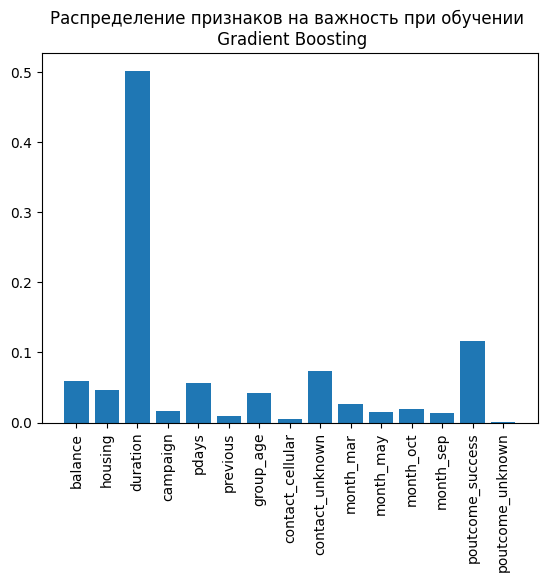

In [51]:
# Оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Построим график для оценки важности признаков
plt.bar(X_train.columns, gradient_boosting.feature_importances_)
plt.xticks(rotation=90);
plt.title("Распределение признаков на важность при обучении \n Gradient Boosting");

Как мы видим по графику, признаки duration/poutcome_success/contact_unknown имеют большую важность при обучении модели Градиентного бустинга.

### Задания 6,7,8

In [52]:
# Реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
    # Задаём пространство для поиска параметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # Создаём модель 
    rf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf
    )
    
    # Обучаем модель
    rf.fit(X_train_scaler, y_train)
    
    # Фиксируем метрику
    score = metrics.f1_score(y_train, rf.predict(X_train_scaler))

    return score 

In [53]:
%%time
# Cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2023-06-21 13:50:57,959] A new study created in memory with name: RandomForestClassifier
[I 2023-06-21 13:50:58,901] Trial 0 finished with value: 0.8455131227408454 and parameters: {'n_estimators': 109, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8455131227408454.
[I 2023-06-21 13:50:59,783] Trial 1 finished with value: 0.8529457727769965 and parameters: {'n_estimators': 121, 'max_depth': 27, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8529457727769965.
[I 2023-06-21 13:51:00,682] Trial 2 finished with value: 0.8694565896314803 and parameters: {'n_estimators': 114, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8694565896314803.
[I 2023-06-21 13:51:02,266] Trial 3 finished with value: 0.8470996216897857 and parameters: {'n_estimators': 195, 'max_depth': 10, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.8694565896314803.
[I 2023-06-21 13:51:03,751] Trial 4 finished with value: 0.874375 and parameters: {'n_estimators

CPU times: total: 24 s
Wall time: 42.2 s


In [54]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 168, 'max_depth': 24, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93


In [55]:
rf_model_opt = ensemble.RandomForestClassifier(**study.best_params, random_state=13)
rf_model_opt.fit(X_train_scaler, y_train)
opt_train_pred = rf_model_opt.predict(X_train_scaler)
opt_test_pred = rf_model_opt.predict(X_test_scaler)
print("Train F1: {:.2f}".format(metrics.f1_score(y_train, opt_train_pred)))
print("Train accuracy: {:.2f}".format(metrics.accuracy_score(y_train, opt_train_pred)))
print("Test F1: {:.2f}".format(metrics.f1_score(y_test, opt_test_pred)))
print("Test accuracy: {:.2f}".format(metrics.accuracy_score(y_test, opt_test_pred)))

Train F1: 0.92
Train accuracy: 0.93
Test F1: 0.82
Test accuracy: 0.83


### <center> ИТОГИ:

При обработки данных выяснил, что большее количество клиентов не имеют депозит, на это могут влиять разные причины, начиная от того, что клиенту не нужен счёт в банке, заканчивая не выгодными условиями для клиента. При построении машины справились с Бизнес задачей банка, показания на метриках accuracy (точность правильных ответов) хорошие (>80), модель можно подавать на выход для применения. 

Зафиксируем версии библиотек.

In [60]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
